In [ ]:
pip install tensorflow keras

     |████████████████████████████████| 462 kB 4.5 MB/s 


In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/")

In [3]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray
from numpy import array
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [4]:
import pandas as pd
import re
import numpy as np
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
nltk.download('punkt') 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Build A Classification Model w/ BBC News / BBC Sport

In [6]:
df = pd.read_csv('news_categories.csv', encoding='cp1252')

In [ ]:
df

,STORY,SECTION
0,But the most painful was the huge reversal in ...,3
1,How formidable is the opposition alliance amon...,0
2,Most Asian currencies were trading lower today...,3
3,"If you want to answer any question, click on ‘...",1
4,"In global markets, gold prices edged up today ...",3
...,...,...
7623,"Karnataka has been a Congress bastion, but it ...",0
7624,"The film, which also features Janhvi Kapoor, w...",2
7625,The database has been created after bringing t...,1
7626,"The state, which has had an uneasy relationshi...",0


Choose section 0 (politics) as my topic.

In [36]:
df['BS'] = df['SECTION'].apply(lambda x: 1 if x == 0 else 0)
df['BS'].value_counts()

0    5942
1    1686
Name: BS, dtype: int64

In [37]:
from numpy.random import seed
seed(42)

Seperate the whole dataset into 50:50

In [38]:
X_train, X_test, y_train, y_test = train_test_split(df['STORY'], df['BS'], test_size=0.5, stratify=df['BS'])

In [39]:
train_docs = X_train.tolist()
test_docs = X_test.tolist()

In [40]:
def get_vec(words, stop=None):
    '''Set up countvectorizer with several parameters, print shape of vectorizer and return vectorizer in DataFrame'''
    vectorizer = CountVectorizer(stop_words=stop, lowercase=True, min_df=0.001) # only keep keywords that appear in more than 0.1% of the reviews
    X = vectorizer.fit_transform(words) 
    X = X.toarray()
    print(X.shape)
    feature = vectorizer.get_feature_names()
    corpus_df = pd.DataFrame(X, columns=feature)
    return corpus_df

In [41]:
corpus_df = get_vec(train_docs, 'english')
corpus_df.sum().sort_values(ascending=False)[:50]

(3814, 7495)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


said          1783
india         1136
new           1002
year           918
bjp            909
congress       855
party          837
people         678
like           669
time           629
modi           545
company        534
data           530
government     522
apple          520
elections      517
state          513
users          507
smartphone     493
minister       467
market         453
film           437
sabha          417
lok            414
000            395
google         394
election       393
years          392
10             388
seats          377
political      374
facebook       373
according      360
app            355
indian         352
million        351
chief          346
world          340
samsung        338
pro            330
just           324
phone          322
delhi          309
camera         304
galaxy         304
work           301
make           301
says           290
display        283
price          281
dtype: int64

In [42]:
## Reference: https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de#file-nltk-lemmatize-sentences-py
lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

def lem(sentence):
    '''Intake a list of review, lemmatize them and return a new list'''
    result_lem = []
    for s in tqdm(sentence):
        s_lem = lemmatize_sentence(s)
        result_lem.append(s_lem)
    return result_lem

In [43]:
def word_replace_post_lem(line):
    '''After lemmitization, do the regex cleaning'''
    line = re.sub(r'\b(bharatiya janata party  )?bjp\b', '_bjp_', line)
    line = re.sub(r'\b(narendra modi)\b', '_narendra_modi_', line)
    line = re.sub(r'\b(new delhi)\b', '_new_delhi_', line)
    line = re.sub(r'\b(lok sabha)\b', '_lok_sabha_', line)
    line = re.sub(r'\b([0-9]+-?)?y(ea)?rs?( |-)old\b', '_year_old_', line)
    return line

In [44]:
def regex_lem(line):
    line = lem(line)
    line = [review.replace('(', '').replace(')', '') for review in line]
    line = [word_replace_post_lem(review.lower()) for review in line]
    return line

In [45]:
stopword_list = stopwords.words("english")

def get_vec(words, stop=stopword_list):
    '''Revise the function by changing stop_words and adding token_pattern'''
    vectorizer = CountVectorizer(stop_words=stop, lowercase=True, min_df=0.001, token_pattern=r'[a-zA-Z\_]{3,}', binary=True)
    X = vectorizer.fit_transform(words) 
    X = X.toarray()
    print(X.shape)
    feature = vectorizer.get_feature_names()
    corpus_df = pd.DataFrame(X, columns=feature)
    return corpus_df

In [46]:
train_docs_lem = regex_lem(train_docs)
train_docs_vec = get_vec(train_docs_lem)
train_docs_vec.sum().sort_values(ascending=False)[:20]

100%|██████████| 3814/3814 [00:26<00:00, 145.97it/s]


(3814, 5983)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


say         1373
also        1044
year         847
india        712
make         697
one          652
time         606
new          598
come         569
like         536
two          528
take         527
company      511
first        503
last         501
party        495
election     483
would        475
use          468
people       462
dtype: int64

In [47]:
test_docs_lem = regex_lem(test_docs)
test_docs_vec = get_vec(test_docs_lem)
test_docs_vec.sum().sort_values(ascending=False)[:20]

100%|██████████| 3814/3814 [00:25<00:00, 148.50it/s]


(3814, 5865)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


say         1444
also        1032
year         857
india        734
make         693
one          643
time         599
new          573
like         567
come         566
take         530
two          521
company      515
election     507
party        504
first        485
last         485
would        470
people       457
market       454
dtype: int64

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=["ner", "pos", "tagger"])
stopwords_removed_train_docs = list(map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), train_docs_lem))
stopwords_removed_test_docs = list(map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), test_docs_lem))

In [49]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=500, oov_token="UNKNOWN_TOKEN")
stopwords_removed_docs = []
for i in stopwords_removed_train_docs:
    stopwords_removed_docs.append(i)
for i in stopwords_removed_test_docs:
    stopwords_removed_docs.append(i)
tokenizer.fit_on_texts(stopwords_removed_docs)

In [50]:
def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

In [51]:
encoded_train_docs = integer_encode_documents(stopwords_removed_train_docs, tokenizer)
encoded_test_docs = integer_encode_documents(stopwords_removed_test_docs, tokenizer)

(array([2.336e+03, 1.149e+03, 2.140e+02, 6.100e+01, 2.800e+01, 1.100e+01,
        6.000e+00, 2.000e+00, 4.000e+00, 3.000e+00]),
 array([  6. ,  63.3, 120.6, 177.9, 235.2, 292.5, 349.8, 407.1, 464.4,
        521.7, 579. ]),
 <a list of 10 Patch objects>)

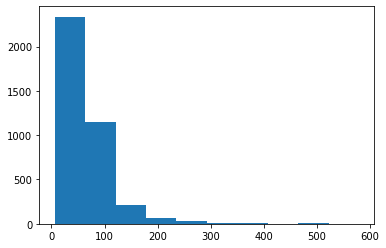

In [52]:
import matplotlib.pyplot as plt
plt.hist(list(map(lambda doc: len(doc), encoded_train_docs)))

(array([1694., 1393.,  517.,  117.,   44.,   20.,   13.,    7.,    6.,
           3.]),
 array([  5. ,  49.4,  93.8, 138.2, 182.6, 227. , 271.4, 315.8, 360.2,
        404.6, 449. ]),
 <a list of 10 Patch objects>)

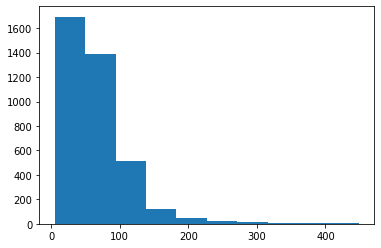

In [53]:
import matplotlib.pyplot as plt
plt.hist(list(map(lambda doc: len(doc), encoded_test_docs)))

After observing the overall length of story, choose 150 as max_length

In [54]:
max_length = 150
padded_train_docs = pad_sequences(encoded_train_docs, maxlen=max_length, padding='post')
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

In [55]:
vocab_size = int(len(tokenizer.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 36983 unique tokens.


In [56]:
EMBEDDING_SIZE = 50

In [57]:
from keras.utils.vis_utils import plot_model

In [58]:
# define the model
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE, input_length=max_length))
model.add(Flatten()) 

model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           1849150   
                                                                 
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 1)                 7501      
                                                                 
Total params: 1,856,651
Trainable params: 1,856,651
Non-trainable params: 0
_________________________________________________________________


In [59]:
# fit the model
model.fit(padded_train_docs, y_train, epochs=50, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(padded_test_docs, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/50
120/120 [==============================] - 3s 22ms/step - loss: 0.4112 - acc: 0.8301
Epoch 2/50
120/120 [==============================] - 3s 23ms/step - loss: 0.1408 - acc: 0.9523
Epoch 3/50
120/120 [==============================] - 3s 22ms/step - loss: 0.0918 - acc: 0.9704
Epoch 4/50
120/120 [==============================] - 2s 20ms/step - loss: 0.0718 - acc: 0.9767
Epoch 5/50
120/120 [==============================] - 3s 25ms/step - loss: 0.0592 - acc: 0.9816
Epoch 6/50
120/120 [==============================] - 2s 19ms/step - loss: 0.0513 - acc: 0.9835
Epoch 7/50
120/120 [==============================] - 2s 19ms/step - loss: 0.0425 - acc: 0.9872
Epoch 8/50
120/120 [==============================] - 2s 19ms/step - loss: 0.0362 - acc: 0.9900
Epoch 9/50
120/120 [==============================] - 3s 21ms/step - loss: 0.0308 - acc: 0.9919
Epoch 10/50
120/120 [==============================] - 3s 23ms/step - loss: 0.0267 - acc: 0.9932
Epoch 11/50
120/120 [==================

## Perform topic modeling

In [60]:
df['STORY_lem'] = regex_lem(df['STORY'].tolist())

100%|██████████| 7628/7628 [00:51<00:00, 147.10it/s]


In [61]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             min_df=0.01, max_df=0.4, stop_words="english")

X = vectorizer.fit_transform(df['STORY_lem'])
terms = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)
print(f"TF-IDF: {tf_idf.shape}")
print(tf_idf.head(5))

TF-IDF: (7628, 53)
   10 year  64gb internal  6gb ram  _bjp_ leader  _lok_sabha_ election  \
0      0.0            0.0      0.0           0.0                   0.0   
1      0.0            0.0      0.0           0.0                   0.0   
2      0.0            0.0      0.0           0.0                   0.0   
3      0.0            0.0      0.0           0.0                   0.0   
4      0.0            0.0      0.0           0.0                   0.0   

   _lok_sabha_ poll  _lok_sabha_ seat  agency fee  artificial intelligence  \
0               0.0               0.0         0.0                      0.0   
1               0.0               0.0         0.0                      0.0   
2               0.0               0.0         0.0                      0.0   
3               0.0               0.0         0.0                      0.0   
4               0.0               0.0         0.0                      0.0   

   assembly election  ...  smartphone maker  social medium  story p

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Since there are four sections in original dataset, I choose n_components = 4.

In [62]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(X)
H = nmf.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [63]:
from typing import List

def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
        print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 5)

TOPIC 0

prime minister (40.5%)

minister _narendra_modi_ (25.1%)

general election (4.1%)

election commission (3.5%)

rahul gandhi (2.9%)

TOPIC 1

social medium (76.2%)

general election (2.5%)

political party (2.5%)

avengers endgame (2.3%)

election commission (2.2%)

TOPIC 2

agency fee (12.0%)

fee modification (12.0%)

wire agency (12.0%)

modification text (12.0%)

story publish (12.0%)

TOPIC 3

_lok_sabha_ election (20.6%)

chief minister (15.6%)

_lok_sabha_ seat (7.1%)

uttar pradesh (6.1%)

general election (4.9%)



In [64]:
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
   sorted_docs = W.argsort(axis=0)[::-1]
   top_docs = sorted_docs[:num_docs].T
   per_document_totals = W.sum(axis=1)
   for topic, top_documents_for_topic in enumerate(top_docs):
       print(f"Topic {topic}")
       for doc in top_documents_for_topic:
           score = W[doc][topic]
           percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
           print(f"{percent_about_topic}%")
           print(documents[doc].replace('\n',''))
       print("=" * 50)

In [65]:
get_top_documents_for_each_topic(W, df['STORY'].tolist(), num_docs=5)

Topic 0
100.0%
A day after Akshay Kumar said he would be getting into an “unknown and uncharted territory” with something he had not done before, the Bollywood actor Tuesday said he will have a “candid and completely non political” chat with Prime Minister Narendra Modi on WednesdayThe 51-year-old star took to Twitter to announce that his conversation with the prime minister will be a “breather” in election time
100.0%
With the introduction of algorithmic ranking which prioritizes?‘engagement’, the?right Facebook comment at the right time is the new gateway to mass attention on the internet. (AFP)From Pakistani propaganda to countering politicians, comments on top Facebook pages are resetting the narrativeIn February, following a terrorist attack by Pakistan-based Jaish-e-Mohammed that killed 40 Indian paramilitary soldiers, and retaliatory air strikes by India on a terrorist training camp in Pakistan’s Balakot, the two nuclear-armed neighbours were on the brink of war.As tensions heig

We can find that there are some duplicate stories in topic 2. After removing those duplicates, I conduct topic modeling again.

In [66]:
df['auto'] = df['STORY'].apply(lambda x: 1 if x == 'This story has been published from a wire agency feed without modifications to the text. Only the headline has been changed.' else 0)

In [67]:
df_drop = df[df['auto'] != 1]

In [68]:
df_drop['STORY'] = df_drop['STORY'].apply(lambda x: x.replace('This story has been published from a wire agency feed without modifications to the text. Only the headline has been changed.', ''))
df_drop['STORY_lem'] = regex_lem(df_drop['STORY'].tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 7600/7600 [00:51<00:00, 147.38it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [69]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             min_df=0.01, max_df=0.4, stop_words="english")

X = vectorizer.fit_transform(df_drop['STORY_lem'])
terms = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)
print(f"TF-IDF: {tf_idf.shape}")
print(tf_idf.head(5))

TF-IDF: (7600, 48)
   10 year  4gb ram  64gb internal  6gb ram  _bjp_ leader  \
0      0.0      0.0            0.0      0.0           0.0   
1      0.0      0.0            0.0      0.0           0.0   
2      0.0      0.0            0.0      0.0           0.0   
3      0.0      0.0            0.0      0.0           0.0   
4      0.0      0.0            0.0      0.0           0.0   

   _lok_sabha_ election  _lok_sabha_ poll  _lok_sabha_ seat  \
0                   0.0               0.0               0.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   

   artificial intelligence  assembly election  ...  samsung galaxy  \
0                      0.0                0.0  ...             0.0   
1                      0.0                0.0  ...             0.0   
2                      0.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(X)
H = nmf.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [71]:
get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 5)

TOPIC 0

prime minister (41.1%)

minister _narendra_modi_ (25.0%)

general election (3.7%)

election commission (3.4%)

rahul gandhi (3.1%)

TOPIC 1

social medium (79.3%)

election commission (3.0%)

political party (2.7%)

general election (2.5%)

san francisco (1.9%)

TOPIC 2

_lok_sabha_ election (20.1%)

chief minister (15.7%)

_lok_sabha_ seat (7.3%)

uttar pradesh (6.2%)

general election (5.5%)

TOPIC 3

mint india (26.0%)

india wire (26.0%)

year ago (15.0%)

avengers endgame (4.7%)

artificial intelligence (3.4%)



In [72]:
get_top_documents_for_each_topic(W, df_drop['STORY'].tolist(), num_docs=5)

Topic 0
100.0%
A day after Akshay Kumar said he would be getting into an “unknown and uncharted territory” with something he had not done before, the Bollywood actor Tuesday said he will have a “candid and completely non political” chat with Prime Minister Narendra Modi on WednesdayThe 51-year-old star took to Twitter to announce that his conversation with the prime minister will be a “breather” in election time
100.0%
With the introduction of algorithmic ranking which prioritizes?‘engagement’, the?right Facebook comment at the right time is the new gateway to mass attention on the internet. (AFP)From Pakistani propaganda to countering politicians, comments on top Facebook pages are resetting the narrativeIn February, following a terrorist attack by Pakistan-based Jaish-e-Mohammed that killed 40 Indian paramilitary soldiers, and retaliatory air strikes by India on a terrorist training camp in Pakistan’s Balakot, the two nuclear-armed neighbours were on the brink of war.As tensions heig

We can conclude that topic 0 and 2 are political stories. Topic 1 also covers politics but it focuses more on how politics issue are spread on social media. Topic 3 contains the technology articles with a major theme in mobile. In order to make topic modeling more accurate, I conduct tf-idf for each section and see if there is any other potential regex target.

In [73]:
def get_tfidf_vec(review):
    '''Intake a list of review and return tf-idf report'''
    vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             token_pattern=r'\b[a-zA-Z\_]{3,}\b',
                             max_df=0.4, stop_words=stopword_list, max_features=1000, binary=True)
    X = vectorizer.fit_transform(review)
    terms = vectorizer.get_feature_names()
    tf_idf = pd.DataFrame(X.toarray().transpose(), index=terms)
    tf_idf = tf_idf.sum(axis=1)
    score = pd.DataFrame(tf_idf, columns=["score"])
    score.sort_values(by="score", ascending=False, inplace=True)
    return score

In [74]:
score_0 = get_tfidf_vec(df_drop[df_drop['SECTION'] == 0]['STORY_lem'])
score_0[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
prime minister,46.512292
_lok_sabha_ election,41.148672
chief minister,40.789811
election commission,34.221876
minister _narendra_modi_,33.875670
rahul gandhi,33.318242
general election,30.254986
_lok_sabha_ seat,29.097551
uttar pradesh,28.884866
political party,27.515219


In [75]:
score_1 = get_tfidf_vec(df_drop[df_drop['SECTION'] == 1]['STORY_lem'])
score_1[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
last year,49.159751
india wire,43.444441
mint india,43.444441
social medium,31.632665
artificial intelligence,29.819619
internal storage,29.804953
ram internal,28.360456
redmi note,27.215732
san francisco,26.170051
allow user,25.044794


In [76]:
score_2 = get_tfidf_vec(df_drop[df_drop['SECTION'] == 2]['STORY_lem'])
score_2[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
avengers endgame,26.527163
social medium,21.761279
box office,19.513814
game thrones,18.164186
actor say,17.965101
_year_old_ actor,17.947849
among others,15.638794
last year,14.732983
also star,14.676381
captain america,12.942677


In [77]:
score_3 = get_tfidf_vec(df_drop[df_drop['SECTION'] == 3]['STORY_lem'])
score_3[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score
last year,19.886421
central bank,19.050397
oil price,17.598257
stock exchange,15.593762
previous close,14.387509
year ago,13.856856
say note,13.518915
march quarter,13.223575
interest rate,12.905770
bond yield,12.342851


In [78]:
def regex_advance(line):
    '''Regex cleaning'''
    line = re.sub(r'\bprime minister\b', '_prime_minister_', line)
    line = re.sub(r'\bchief minister\b', '_chief_minister_', line)
    line = re.sub(r'\brahul gandhi\b', '_rahul_gandhi_', line)
    line = re.sub(r'\buttar pradesh\b', '_uttar_pradesh_', line)
    line = re.sub(r'\bmint\-india\-wire\b', '_mint_india_', line)
    line = re.sub(r'\bredmi note\b', '_redmi_note_', line)
    line = re.sub(r'\bsamsung galaxy\b', '_samsung_galaxy_', line)
    line = re.sub(r'\bavengers?(endgame)?\b', '_avengers_', line)
    line = re.sub(r'\bbox office\b', '_box_office_', line)
    line = re.sub(r'\bgame of thrones\b', '_game_of_thrones_', line)
    line = re.sub(r'\binfinity war\b', '_infinity_war_', line)
    line = re.sub(r'\bcaptain america\b', '_captain_america_', line)
    line = re.sub(r'\binterest rate\b', '_interest_rate_', line)
    line = re.sub(r'\bfiscal year\b', '_fiscal_year_', line)
    return line

In [79]:
df_drop['STORY_lem'] = df_drop['STORY_lem'].apply(lambda x: regex_advance(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [80]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             min_df=0.01, max_df=0.4, stop_words="english")

X = vectorizer.fit_transform(df_drop['STORY_lem'])
terms = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)
print(f"TF-IDF: {tf_idf.shape}")
print(tf_idf.head(5))

TF-IDF: (7600, 39)
   10 year  4gb ram  64gb internal  6gb ram  _avengers_ endgame  _bjp_ leader  \
0      0.0      0.0            0.0      0.0                 0.0           0.0   
1      0.0      0.0            0.0      0.0                 0.0           0.0   
2      0.0      0.0            0.0      0.0                 0.0           0.0   
3      0.0      0.0            0.0      0.0                 0.0           0.0   
4      0.0      0.0            0.0      0.0                 0.0           0.0   

   _lok_sabha_ election  _lok_sabha_ poll  _lok_sabha_ seat  \
0                   0.0               0.0               0.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   

   _prime_minister_ _narendra_modi_  ...  qualcomm snapdragon  ram 64gb  \
0                               0.0  ...

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [81]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(X)
H = nmf.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [82]:
get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 10)

TOPIC 0

social medium (83.1%)

election commission (2.7%)

political party (2.6%)

san francisco (2.1%)

_avengers_ endgame (1.5%)

artificial intelligence (1.3%)

say statement (1.2%)

new york (0.8%)

janata party (0.8%)

congress party (0.8%)

TOPIC 1

_lok_sabha_ election (69.3%)

assembly election (7.1%)

election commission (4.5%)

janata dal (3.0%)

west bengal (2.3%)

political party (2.2%)

congress president (2.0%)

_lok_sabha_ poll (1.7%)

president _rahul_gandhi_ (1.5%)

union minister (1.3%)

TOPIC 2

_prime_minister_ _narendra_modi_ (20.3%)

general election (17.0%)

_lok_sabha_ seat (8.8%)

election commission (5.8%)

congress president (4.1%)

congress party (4.0%)

assembly election (3.9%)

_lok_sabha_ poll (3.7%)

west bengal (3.5%)

president _rahul_gandhi_ (3.4%)

TOPIC 3

year ago (66.7%)

_avengers_ endgame (16.1%)

company say (2.9%)

central bank (2.0%)

vice president (1.7%)

new york (1.7%)

san francisco (1.5%)

10 year 

In [83]:
get_top_documents_for_each_topic(W, df_drop['STORY_lem'].tolist(), num_docs=5)

Topic 0
100.0%
outdoor advertising continue to remain a crucial medium for party to connect with voter , despite the grow popularity of digital and social medium platform . “ outdoor have specific nuance , which be physical and locational in nature . it can not be switch off , skip or block . it be this physical presence that make it the most transparent of medium , '' say sujit banerjee , director and chief executive of ecosys , a specialist outdoor agency under publicis media . outdoor ad be expect to feature political leader with contextual conversation and a display of their achievement .
100.0%
actors like sivakarthikeyan , radhikaa sarathkumar and others take to social medium to wish actor ajith on his 48th birthday while sivakarthikeyan tweet , “ happy birthday to our dear thala ajith sir ? ? ? ? ? ? ” , veteran actor radhikaa sarathkumar , who collaborate with ajith in pavithra and amarkalam , post her wish on twitter and ask him to continue his good work he write , “ wishing a

After conducting second round regex, we still cannot improve the performance of topic modeling. The possible reason to this problem will be duplicated keywords. For example, "social medium" appears in frequent wordlists of section 0, 1 and 2. Therefore, they mix up with each other in topic 0, 1 and 2. As for topic 3, it's composed of section 1, 2 and 3 becuase they also share "last year" as common keyword. Next, we will remove these common keywords and conduct topic modeling again.

In [84]:
def regex_remove_freq(line):
    '''Remove common keywords'''
    line = re.sub(r'\blast year\b', '', line)
    line = re.sub(r'\byear ago\b', '', line)
    line = re.sub(r'\bsocial medium\b', '', line)
    return line

In [85]:
df_drop['STORY_lem'] = df_drop['STORY_lem'].apply(lambda x: regex_remove_freq(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             min_df=0.01, max_df=0.4, stop_words="english")

X = vectorizer.fit_transform(df_drop['STORY_lem'])
terms = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray(), columns=terms)
print(f"TF-IDF: {tf_idf.shape}")
print(tf_idf.head(5))

TF-IDF: (7600, 37)
   10 year  4gb ram  64gb internal  6gb ram  _avengers_ endgame  _bjp_ leader  \
0      0.0      0.0            0.0      0.0                 0.0           0.0   
1      0.0      0.0            0.0      0.0                 0.0           0.0   
2      0.0      0.0            0.0      0.0                 0.0           0.0   
3      0.0      0.0            0.0      0.0                 0.0           0.0   
4      0.0      0.0            0.0      0.0                 0.0           0.0   

   _lok_sabha_ election  _lok_sabha_ poll  _lok_sabha_ seat  \
0                   0.0               0.0               0.0   
1                   0.0               0.0               0.0   
2                   0.0               0.0               0.0   
3                   0.0               0.0               0.0   
4                   0.0               0.0               0.0   

   _prime_minister_ _narendra_modi_  ...  political party  \
0                               0.0  ...              

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [87]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(X)
H = nmf.components_

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


In [88]:
get_top_tf_idf_tokens_for_topic(H, tf_idf.columns.tolist(), 10)

TOPIC 0

_lok_sabha_ election (68.2%)

assembly election (6.9%)

election commission (5.1%)

janata dal (2.9%)

west bengal (2.3%)

political party (2.1%)

congress president (2.0%)

_lok_sabha_ poll (1.8%)

president _rahul_gandhi_ (1.6%)

union minister (1.4%)

TOPIC 1

_prime_minister_ _narendra_modi_ (20.2%)

general election (18.1%)

_lok_sabha_ seat (8.1%)

election commission (6.0%)

congress party (4.0%)

congress president (4.0%)

assembly election (3.7%)

_lok_sabha_ poll (3.5%)

political party (3.4%)

west bengal (3.3%)

TOPIC 2

_avengers_ endgame (91.6%)

new york (2.6%)

10 year (1.5%)

san francisco (1.3%)

smartphone maker (1.1%)

vice president (1.0%)

central bank (0.4%)

artificial intelligence (0.2%)

company say (0.2%)

oil price (0.1%)

TOPIC 3

internal storage (28.6%)

6gb ram (12.3%)

64gb internal (11.8%)

ram 64gb (11.8%)

qualcomm snapdragon (10.7%)

4gb ram (9.4%)

camera setup (7.1%)

smartphone maker (5.1%)

san fra

In [89]:
get_top_documents_for_each_topic(W, df_drop['STORY'].tolist(), num_docs=5)

Topic 0
100.0%
He compared the Lok Sabha elections to a contest between 'Ali', a revered figure in Islam, and Bajrang Bali, the Hindu god Hanuman.
100.0%
”Also read | Lok Sabha Elections 2019 Phase 3 LIVE newsVoting began at 7 am on Tuesday as 116 constituencies across 15 states and union territories go to polls in the third and largest phase of Lok Sabha electionsMeanwhile, Anupam Kher, Shah Rukh Khan and many other celebrities from the entertainment industry urged people to come out in huge numbers to vote
100.0%
The Lok Sabha election in the state will be held in seven phases with the first one on 11 April and the last on 19 May
100.0%
He also stated that a meeting of TPCC coordination committee would be held on 16 February to discuss alliances and that the party’s election committee will meet to shortlist the candidates for Lok Sabha elections on 17 February.
100.0%
In an ideal world, this should have been the election in which Kanhaiya Kumar, and the millions of young Indians like

After we remove common keywords, politics stories are classified as topic 0 and 1. Topic 2 are filled with entertainment and business articles. As for topic 3, we can see that most of the articles are technology. 